In [3]:
import pandas as pd
import numpy as np
import random 

from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, mean_absolute_error

import xgboost
import numerapi
NAPI = numerapi.NumerAPI(verbosity="info")
import random as rn
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr
from bayes_opt import BayesianOptimization
import os
import pickle

from helpers.utils import *
from helpers.xgboost_feval import *
from models.qurty.data_preparation import prepare_data

In [7]:
DIR = "/Users/brianbroeking/projects/numerai/data"
train, tournament = prepare_data()

You already have the newest data! Current round is: 261
Loading the data


In [8]:
def ar1(x):
    return np.corrcoef(x[:-1], x[1:])[0,1]

def autocorr_penalty(x):
    n = len(x)
    p = ar1(x)
    return np.sqrt(1 + 2*np.sum([((n - i)/n)*p**i for i in range(1,n)]))

def smart_sharpe(x):
    return np.mean(x)/(np.std(x, ddof=1)*autocorr_penalty(x))

In [24]:
def era_boost_train(X, y, era_col, proportion=0.5,
                    trees_per_step=10, num_iters=200,
                    one_shot=False, tree_method='hist',
                    test_model=None, note=None):
    print(f"\n#### Era boost train with proportion {proportion:0.3f} ####\n")
    if note is not None:
        print(note)
    if one_shot:
        trees_per_step = trees_per_step * num_iters
        num_iters=1

    if test_model is None:
        print(f"Train {num_iters} iterations")
        print(f"Train {trees_per_step} rounds per iteration")
    else:
        print("Testing model performance")
    features = X.columns
    new_df = X.copy()
    new_df["target"] = y
    new_df["era"] = era_col
    params = {
        'objective': 'reg:squarederror',
        'n_estimators': 25,
        'learning_rate': 0.05,
        'colsample_bytree': 0.1,
        'gamma': 0.2, # trained at gammas 1,2,.75,.3
        'alpha': 7,
        'lambda': 9,
        'max_depth': 7,
        'min_child_weight': 16
    }
    for i in range(num_iters):
        print(f"\nIteration {i+1}:\n")
        if test_model is None:
            if i==0:
                model = xgboost.XGBRegressor(**params,
                                             n_jobs=-1,
                                             tree_method=tree_method)
                model.fit(X, y)
            else:
                model.n_estimators += trees_per_step
                booster = model.get_booster()
                print("fitting on worst eras")
                model.fit(worst_df[features], worst_df["target"], xgb_model=booster)
        else:
            if i == 0:
                model = test_model
            else:
                model.n_estimators += trees_per_step
                booster = model.get_booster()
                print("fitting on worst eras")
                model.fit(worst_df[features], worst_df["target"], xgb_model=booster)
        # score each era
        print("predicting on train")
        preds = model.predict(X)
        new_df["pred"] = preds
        era_scores = pd.Series(index=new_df["era"].unique())
        print("getting per era scores")
        for era in new_df["era"].unique():
            era_df = new_df[new_df["era"] == era]
            print(spearmanr(era_df["pred"], era_df["target"])[0])
            era_scores[era] = spearmanr(era_df["pred"], era_df["target"])[0]
        era_scores.sort_values(inplace=True)
        worst_eras = era_scores[era_scores <= era_scores.quantile(proportion)].index
        print(list(worst_eras))
        worst_df = new_df[new_df["era"].isin(worst_eras)]
        era_scores.sort_index(inplace=True)
        era_scores.plot(kind="bar")
        print("performance over time")
        plt.show()
        print("autocorrelation")
        print(ar1(era_scores))
#         if (ar1(era_scores)) < 0.1:
#             return model
        print("mean correlation")
        print(np.mean(era_scores))
        print("sharpe")
        print(np.mean(era_scores)/np.std(era_scores))
        print("smart sharpe")
        print(smart_sharpe(era_scores))
    return model

In [25]:
X_train, y_train = clean_for_xgboost(train)


#### Era boost train with proportion 0.500 ####

Testing model performance

Iteration 1:

predicting on train


<ipython-input-24-39efca956e6c>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.061048381656930745
0.047402931224543324
0.046687313911263656
0.10087613943522063
0.09103400230464122
0.060290270429914895
0.03339782099160801
0.07652187308965422
0.026796958978905938
0.0914849406315811
0.09162892560662596
0.07365193205589916
0.07155840750628117
0.043572343015805926
0.05321532849879735
0.10275052123423407
0.03780976619891385
0.0411929466352335
0.046025290677995594
0.060678333833281466
0.03927170397769158
0.08697002992481032
0.08084696020380971
0.054449150597566824
0.04899909367479318
0.04280765652921579
0.03193738372998491
0.04386703017761775
0.05954659472462082
0.09663418300348028
0.04456192210532786
0.025764752687303265
0.023636603912500737
0.021647001507083333
0.043533207367250706
0.09983984380261478
0.05806963001065034
0.06928901350577403
0.07316742549727075
0.05084987747751703
-0.0136922364394493
0.04163243003734201
0.040456377952003686
0.06851754584958586
0.07051377305499694
0.03101387796896957
0.06514941304428612
0.08588542470385327
0.037

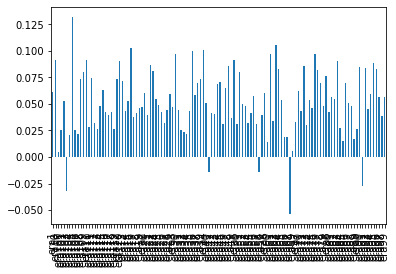

autocorrelation
0.06106744183262212
mean correlation
0.05107706785469266
sharpe
1.7163360253313653
smart sharpe
1.608617659569999

Iteration 2:

fitting on worst eras
predicting on train


<ipython-input-24-39efca956e6c>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.061048381656930745
0.047402931224543324
0.046687313911263656
0.10087613943522063
0.09103400230464122
0.060290270429914895
0.03339782099160801
0.07652187308965422
0.026796958978905938
0.0914849406315811
0.09162892560662596
0.07365193205589916
0.07155840750628117
0.043572343015805926
0.05321532849879735
0.10275052123423407
0.03780976619891385
0.0411929466352335
0.046025290677995594
0.060678333833281466
0.03927170397769158
0.08697002992481032
0.08084696020380971
0.054449150597566824
0.04899909367479318
0.04280765652921579
0.03193738372998491
0.04386703017761775
0.05954659472462082
0.09663418300348028
0.04456192210532786
0.025764752687303265
0.023636603912500737
0.021647001507083333
0.043533207367250706
0.09983984380261478
0.05806963001065034
0.06928901350577403
0.07316742549727075
0.05084987747751703
-0.0136922364394493
0.04163243003734201
0.040456377952003686
0.06851754584958586
0.07051377305499694
0.03101387796896957
0.06514941304428612
0.08588542470385327
0.037

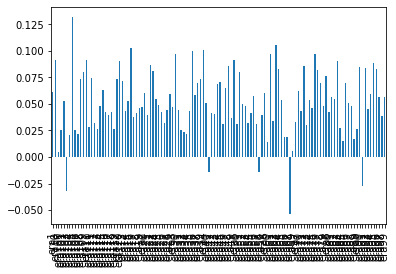

autocorrelation
0.06106744183262212
mean correlation
0.05107706785469266
sharpe
1.7163360253313653
smart sharpe
1.608617659569999

Iteration 3:

fitting on worst eras
predicting on train


<ipython-input-24-39efca956e6c>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.061048381656930745
0.047402931224543324
0.046687313911263656
0.10087613943522063
0.09103400230464122
0.060290270429914895
0.03339782099160801
0.07652187308965422
0.026796958978905938
0.0914849406315811
0.09162892560662596
0.07365193205589916
0.07155840750628117
0.043572343015805926
0.05321532849879735
0.10275052123423407
0.03780976619891385
0.0411929466352335
0.046025290677995594
0.060678333833281466
0.03927170397769158
0.08697002992481032
0.08084696020380971
0.054449150597566824
0.04899909367479318
0.04280765652921579
0.03193738372998491
0.04386703017761775
0.05954659472462082
0.09663418300348028
0.04456192210532786
0.025764752687303265
0.023636603912500737
0.021647001507083333
0.043533207367250706
0.09983984380261478
0.05806963001065034
0.06928901350577403
0.07316742549727075
0.05084987747751703
-0.0136922364394493
0.04163243003734201
0.040456377952003686
0.06851754584958586
0.07051377305499694
0.03101387796896957
0.06514941304428612
0.08588542470385327
0.037

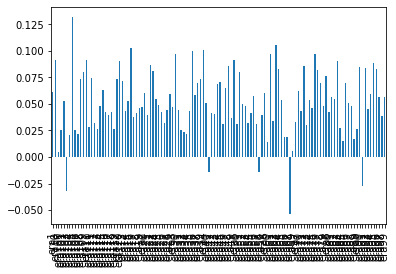

autocorrelation
0.06106744183262212
mean correlation
0.05107706785469266
sharpe
1.7163360253313653
smart sharpe
1.608617659569999

Iteration 4:

fitting on worst eras
predicting on train


<ipython-input-24-39efca956e6c>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.061048381656930745
0.047402931224543324
0.046687313911263656
0.10087613943522063
0.09103400230464122
0.060290270429914895
0.03339782099160801
0.07652187308965422
0.026796958978905938
0.0914849406315811
0.09162892560662596
0.07365193205589916
0.07155840750628117
0.043572343015805926
0.05321532849879735
0.10275052123423407
0.03780976619891385
0.0411929466352335
0.046025290677995594
0.060678333833281466
0.03927170397769158
0.08697002992481032
0.08084696020380971
0.054449150597566824
0.04899909367479318
0.04280765652921579
0.03193738372998491
0.04386703017761775
0.05954659472462082
0.09663418300348028
0.04456192210532786
0.025764752687303265
0.023636603912500737
0.021647001507083333
0.043533207367250706
0.09983984380261478
0.05806963001065034
0.06928901350577403
0.07316742549727075
0.05084987747751703
-0.0136922364394493
0.04163243003734201
0.040456377952003686
0.06851754584958586
0.07051377305499694
0.03101387796896957
0.06514941304428612
0.08588542470385327
0.037

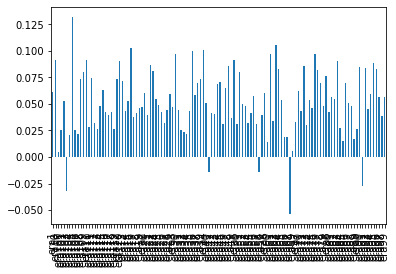

autocorrelation
0.06106744183262212
mean correlation
0.05107706785469266
sharpe
1.7163360253313653
smart sharpe
1.608617659569999

Iteration 5:

fitting on worst eras
predicting on train


<ipython-input-24-39efca956e6c>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.061048381656930745
0.047402931224543324
0.046687313911263656
0.10087613943522063
0.09103400230464122
0.060290270429914895
0.03339782099160801
0.07652187308965422
0.026796958978905938
0.0914849406315811
0.09162892560662596
0.07365193205589916
0.07155840750628117
0.043572343015805926
0.05321532849879735
0.10275052123423407
0.03780976619891385
0.0411929466352335
0.046025290677995594
0.060678333833281466
0.03927170397769158
0.08697002992481032
0.08084696020380971
0.054449150597566824
0.04899909367479318
0.04280765652921579
0.03193738372998491
0.04386703017761775
0.05954659472462082
0.09663418300348028
0.04456192210532786
0.025764752687303265
0.023636603912500737
0.021647001507083333
0.043533207367250706
0.09983984380261478
0.05806963001065034
0.06928901350577403
0.07316742549727075
0.05084987747751703
-0.0136922364394493
0.04163243003734201
0.040456377952003686
0.06851754584958586
0.07051377305499694
0.03101387796896957
0.06514941304428612
0.08588542470385327
0.037

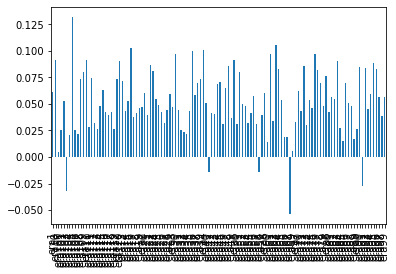

autocorrelation
0.06106744183262212
mean correlation
0.05107706785469266
sharpe
1.7163360253313653
smart sharpe
1.608617659569999

Iteration 6:

fitting on worst eras
predicting on train


<ipython-input-24-39efca956e6c>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.061048381656930745
0.047402931224543324
0.046687313911263656
0.10087613943522063
0.09103400230464122
0.060290270429914895
0.03339782099160801
0.07652187308965422
0.026796958978905938
0.0914849406315811
0.09162892560662596
0.07365193205589916
0.07155840750628117
0.043572343015805926
0.05321532849879735
0.10275052123423407
0.03780976619891385
0.0411929466352335
0.046025290677995594
0.060678333833281466
0.03927170397769158
0.08697002992481032
0.08084696020380971
0.054449150597566824
0.04899909367479318
0.04280765652921579
0.03193738372998491
0.04386703017761775
0.05954659472462082
0.09663418300348028
0.04456192210532786
0.025764752687303265
0.023636603912500737
0.021647001507083333
0.043533207367250706
0.09983984380261478
0.05806963001065034
0.06928901350577403
0.07316742549727075
0.05084987747751703
-0.0136922364394493
0.04163243003734201
0.040456377952003686
0.06851754584958586
0.07051377305499694
0.03101387796896957
0.06514941304428612
0.08588542470385327
0.037

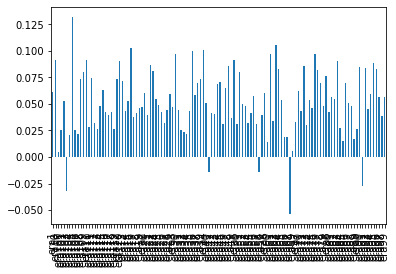

autocorrelation
0.06106744183262212
mean correlation
0.05107706785469266
sharpe
1.7163360253313653
smart sharpe
1.608617659569999

Iteration 7:

fitting on worst eras
predicting on train


<ipython-input-24-39efca956e6c>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.061048381656930745
0.047402931224543324
0.046687313911263656
0.10087613943522063
0.09103400230464122
0.060290270429914895
0.03339782099160801
0.07652187308965422
0.026796958978905938
0.0914849406315811
0.09162892560662596
0.07365193205589916
0.07155840750628117
0.043572343015805926
0.05321532849879735
0.10275052123423407
0.03780976619891385
0.0411929466352335
0.046025290677995594
0.060678333833281466
0.03927170397769158
0.08697002992481032
0.08084696020380971
0.054449150597566824
0.04899909367479318
0.04280765652921579
0.03193738372998491
0.04386703017761775
0.05954659472462082
0.09663418300348028
0.04456192210532786
0.025764752687303265
0.023636603912500737
0.021647001507083333
0.043533207367250706
0.09983984380261478
0.05806963001065034
0.06928901350577403
0.07316742549727075
0.05084987747751703
-0.0136922364394493
0.04163243003734201
0.040456377952003686
0.06851754584958586
0.07051377305499694
0.03101387796896957
0.06514941304428612
0.08588542470385327
0.037

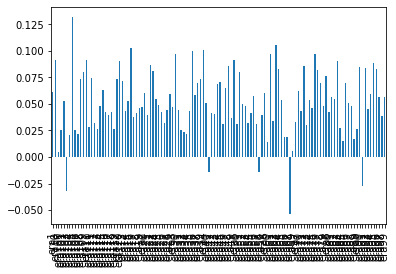

autocorrelation
0.06106744183262212
mean correlation
0.05107706785469266
sharpe
1.7163360253313653
smart sharpe
1.608617659569999

Iteration 8:

fitting on worst eras
predicting on train


<ipython-input-24-39efca956e6c>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.061048381656930745
0.047402931224543324
0.046687313911263656
0.10087613943522063
0.09103400230464122
0.060290270429914895
0.03339782099160801
0.07652187308965422
0.026796958978905938
0.0914849406315811
0.09162892560662596
0.07365193205589916
0.07155840750628117
0.043572343015805926
0.05321532849879735
0.10275052123423407
0.03780976619891385
0.0411929466352335
0.046025290677995594
0.060678333833281466
0.03927170397769158
0.08697002992481032
0.08084696020380971
0.054449150597566824
0.04899909367479318
0.04280765652921579
0.03193738372998491
0.04386703017761775
0.05954659472462082
0.09663418300348028
0.04456192210532786
0.025764752687303265
0.023636603912500737
0.021647001507083333
0.043533207367250706
0.09983984380261478
0.05806963001065034
0.06928901350577403
0.07316742549727075
0.05084987747751703
-0.0136922364394493
0.04163243003734201
0.040456377952003686
0.06851754584958586
0.07051377305499694
0.03101387796896957
0.06514941304428612
0.08588542470385327
0.037

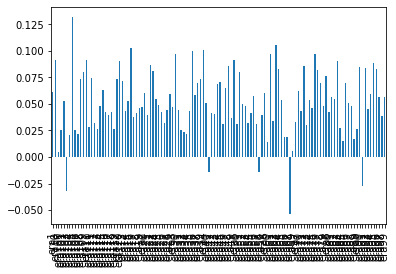

autocorrelation
0.06106744183262212
mean correlation
0.05107706785469266
sharpe
1.7163360253313653
smart sharpe
1.608617659569999

Iteration 9:

fitting on worst eras
predicting on train


<ipython-input-24-39efca956e6c>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.061048381656930745
0.047402931224543324
0.046687313911263656
0.10087613943522063
0.09103400230464122
0.060290270429914895
0.03339782099160801
0.07652187308965422
0.026796958978905938
0.0914849406315811
0.09162892560662596
0.07365193205589916
0.07155840750628117
0.043572343015805926
0.05321532849879735
0.10275052123423407
0.03780976619891385
0.0411929466352335
0.046025290677995594
0.060678333833281466
0.03927170397769158
0.08697002992481032
0.08084696020380971
0.054449150597566824
0.04899909367479318
0.04280765652921579
0.03193738372998491
0.04386703017761775
0.05954659472462082
0.09663418300348028
0.04456192210532786
0.025764752687303265
0.023636603912500737
0.021647001507083333
0.043533207367250706
0.09983984380261478
0.05806963001065034
0.06928901350577403
0.07316742549727075
0.05084987747751703
-0.0136922364394493
0.04163243003734201
0.040456377952003686
0.06851754584958586
0.07051377305499694
0.03101387796896957
0.06514941304428612
0.08588542470385327
0.037

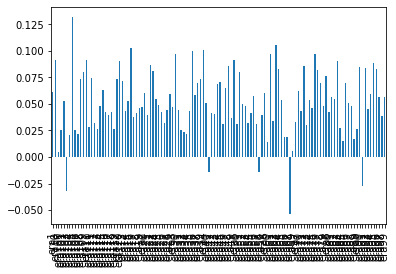

autocorrelation
0.06106744183262212
mean correlation
0.05107706785469266
sharpe
1.7163360253313653
smart sharpe
1.608617659569999

Iteration 10:

fitting on worst eras
predicting on train


<ipython-input-24-39efca956e6c>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.061048381656930745
0.047402931224543324
0.046687313911263656
0.10087613943522063
0.09103400230464122
0.060290270429914895
0.03339782099160801
0.07652187308965422
0.026796958978905938
0.0914849406315811
0.09162892560662596
0.07365193205589916
0.07155840750628117
0.043572343015805926
0.05321532849879735
0.10275052123423407
0.03780976619891385
0.0411929466352335
0.046025290677995594
0.060678333833281466
0.03927170397769158
0.08697002992481032
0.08084696020380971
0.054449150597566824
0.04899909367479318
0.04280765652921579
0.03193738372998491
0.04386703017761775
0.05954659472462082
0.09663418300348028
0.04456192210532786
0.025764752687303265
0.023636603912500737
0.021647001507083333
0.043533207367250706
0.09983984380261478
0.05806963001065034
0.06928901350577403
0.07316742549727075
0.05084987747751703
-0.0136922364394493
0.04163243003734201
0.040456377952003686
0.06851754584958586
0.07051377305499694
0.03101387796896957
0.06514941304428612
0.08588542470385327
0.037

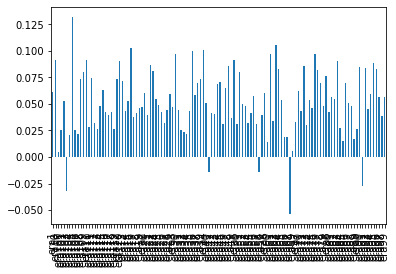

autocorrelation
0.06106744183262212
mean correlation
0.05107706785469266
sharpe
1.7163360253313653
smart sharpe
1.608617659569999

Iteration 11:

fitting on worst eras
predicting on train


<ipython-input-24-39efca956e6c>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.061048381656930745
0.047402931224543324
0.046687313911263656
0.10087613943522063
0.09103400230464122
0.060290270429914895
0.03339782099160801
0.07652187308965422
0.026796958978905938
0.0914849406315811
0.09162892560662596
0.07365193205589916
0.07155840750628117
0.043572343015805926
0.05321532849879735
0.10275052123423407
0.03780976619891385
0.0411929466352335
0.046025290677995594
0.060678333833281466
0.03927170397769158
0.08697002992481032
0.08084696020380971
0.054449150597566824
0.04899909367479318
0.04280765652921579
0.03193738372998491
0.04386703017761775
0.05954659472462082
0.09663418300348028
0.04456192210532786
0.025764752687303265
0.023636603912500737
0.021647001507083333
0.043533207367250706
0.09983984380261478
0.05806963001065034
0.06928901350577403
0.07316742549727075
0.05084987747751703
-0.0136922364394493
0.04163243003734201
0.040456377952003686
0.06851754584958586
0.07051377305499694
0.03101387796896957
0.06514941304428612
0.08588542470385327
0.037

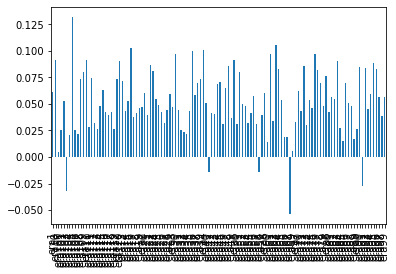

autocorrelation
0.06106744183262212
mean correlation
0.05107706785469266
sharpe
1.7163360253313653
smart sharpe
1.608617659569999

Iteration 12:

fitting on worst eras
predicting on train


<ipython-input-24-39efca956e6c>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.061048381656930745
0.047402931224543324
0.046687313911263656
0.10087613943522063
0.09103400230464122
0.060290270429914895
0.03339782099160801
0.07652187308965422
0.026796958978905938
0.0914849406315811
0.09162892560662596
0.07365193205589916
0.07155840750628117
0.043572343015805926
0.05321532849879735
0.10275052123423407
0.03780976619891385
0.0411929466352335
0.046025290677995594
0.060678333833281466
0.03927170397769158
0.08697002992481032
0.08084696020380971
0.054449150597566824
0.04899909367479318
0.04280765652921579
0.03193738372998491
0.04386703017761775
0.05954659472462082
0.09663418300348028
0.04456192210532786
0.025764752687303265
0.023636603912500737
0.021647001507083333
0.043533207367250706
0.09983984380261478
0.05806963001065034
0.06928901350577403
0.07316742549727075
0.05084987747751703
-0.0136922364394493
0.04163243003734201
0.040456377952003686
0.06851754584958586
0.07051377305499694
0.03101387796896957
0.06514941304428612
0.08588542470385327
0.037

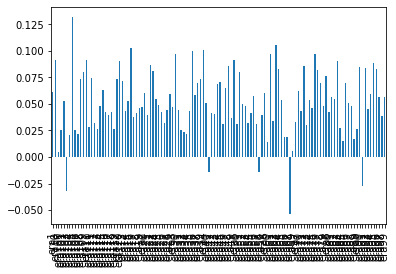

autocorrelation
0.06106744183262212
mean correlation
0.05107706785469266
sharpe
1.7163360253313653
smart sharpe
1.608617659569999

Iteration 13:

fitting on worst eras
predicting on train


<ipython-input-24-39efca956e6c>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.061048381656930745
0.047402931224543324
0.046687313911263656
0.10087613943522063
0.09103400230464122
0.060290270429914895
0.03339782099160801
0.07652187308965422
0.026796958978905938
0.0914849406315811
0.09162892560662596
0.07365193205589916
0.07155840750628117
0.043572343015805926
0.05321532849879735
0.10275052123423407
0.03780976619891385
0.0411929466352335
0.046025290677995594
0.060678333833281466
0.03927170397769158
0.08697002992481032
0.08084696020380971
0.054449150597566824
0.04899909367479318
0.04280765652921579
0.03193738372998491
0.04386703017761775
0.05954659472462082
0.09663418300348028
0.04456192210532786
0.025764752687303265
0.023636603912500737
0.021647001507083333
0.043533207367250706
0.09983984380261478
0.05806963001065034
0.06928901350577403
0.07316742549727075
0.05084987747751703
-0.0136922364394493
0.04163243003734201
0.040456377952003686
0.06851754584958586
0.07051377305499694
0.03101387796896957
0.06514941304428612
0.08588542470385327
0.037

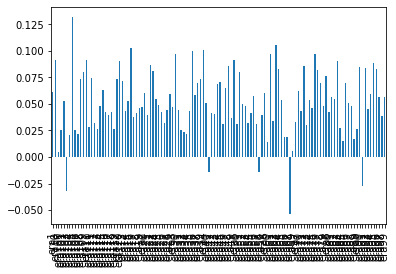

autocorrelation
0.06106744183262212
mean correlation
0.05107706785469266
sharpe
1.7163360253313653
smart sharpe
1.608617659569999

Iteration 14:

fitting on worst eras
predicting on train


<ipython-input-24-39efca956e6c>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.061048381656930745
0.047402931224543324
0.046687313911263656
0.10087613943522063
0.09103400230464122
0.060290270429914895
0.03339782099160801
0.07652187308965422
0.026796958978905938
0.0914849406315811
0.09162892560662596
0.07365193205589916
0.07155840750628117
0.043572343015805926
0.05321532849879735
0.10275052123423407
0.03780976619891385
0.0411929466352335
0.046025290677995594
0.060678333833281466
0.03927170397769158
0.08697002992481032
0.08084696020380971
0.054449150597566824
0.04899909367479318
0.04280765652921579
0.03193738372998491
0.04386703017761775
0.05954659472462082
0.09663418300348028
0.04456192210532786
0.025764752687303265
0.023636603912500737
0.021647001507083333
0.043533207367250706
0.09983984380261478
0.05806963001065034
0.06928901350577403
0.07316742549727075
0.05084987747751703
-0.0136922364394493
0.04163243003734201
0.040456377952003686
0.06851754584958586
0.07051377305499694
0.03101387796896957
0.06514941304428612
0.08588542470385327
0.037

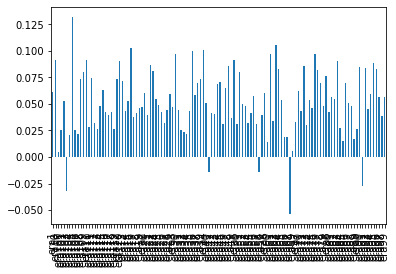

autocorrelation
0.06106744183262212
mean correlation
0.05107706785469266
sharpe
1.7163360253313653
smart sharpe
1.608617659569999

Iteration 15:

fitting on worst eras
predicting on train


<ipython-input-24-39efca956e6c>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.061048381656930745
0.047402931224543324
0.046687313911263656
0.10087613943522063
0.09103400230464122
0.060290270429914895
0.03339782099160801
0.07652187308965422
0.026796958978905938
0.0914849406315811
0.09162892560662596
0.07365193205589916
0.07155840750628117
0.043572343015805926
0.05321532849879735
0.10275052123423407
0.03780976619891385
0.0411929466352335
0.046025290677995594
0.060678333833281466
0.03927170397769158
0.08697002992481032
0.08084696020380971
0.054449150597566824
0.04899909367479318
0.04280765652921579
0.03193738372998491
0.04386703017761775
0.05954659472462082
0.09663418300348028
0.04456192210532786
0.025764752687303265
0.023636603912500737
0.021647001507083333
0.043533207367250706
0.09983984380261478
0.05806963001065034
0.06928901350577403
0.07316742549727075
0.05084987747751703
-0.0136922364394493
0.04163243003734201
0.040456377952003686
0.06851754584958586
0.07051377305499694
0.03101387796896957
0.06514941304428612
0.08588542470385327
0.037

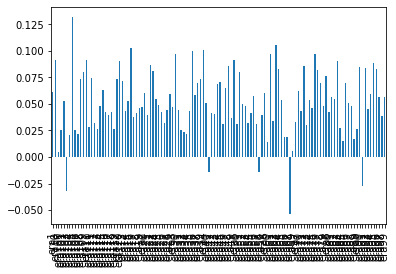

autocorrelation
0.06106744183262212
mean correlation
0.05107706785469266
sharpe
1.7163360253313653
smart sharpe
1.608617659569999

Iteration 16:

fitting on worst eras
predicting on train


<ipython-input-24-39efca956e6c>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.06115476116888174
0.04930030689251854
0.049134561736275756
0.10173129596064096
0.08934445081189057
0.06025251042263255
0.03508570509892798
0.0742448506978432
0.02823405038036954
0.09090193413110002
0.09004690951049656
0.07276685959775724
0.07043437817863663
0.04254459175824658
0.055346198818851354
0.10494050905133462
0.03846843975850327
0.04174800124812465
0.045322202810781816
0.05953445052304338
0.041225346520951604
0.08670951535024003
0.081039135133435
0.05521163601125949
0.049681170994174885
0.045756597911798313
0.03222883981821822
0.04478554645996626
0.05768954923683239
0.09753407102045619
0.04481668463952245
0.025736745046537883
0.0239259037836097
0.021916360723126974
0.044280758628009724
0.1021325804692025
0.05809983059377535
0.06938264235202504
0.07290306971673347
0.05067381419979453
-0.013065524021685645
0.04333020607762306
0.0412099816461278
0.06929995975463263
0.07121353359597488
0.0307089551367908
0.0643942076461833
0.08533328033108224
0.037936940079

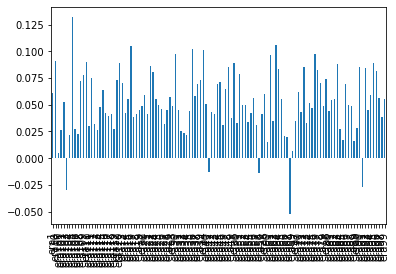

autocorrelation
0.06438256069515247
mean correlation
0.05138651185906224
sharpe
1.748514857626629
smart sharpe
1.6333774964498025

Iteration 17:

fitting on worst eras
predicting on train


<ipython-input-24-39efca956e6c>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.06115476116888174
0.04930030689251854
0.049134561736275756
0.10173129596064096
0.08934445081189057
0.06025251042263255
0.03508570509892798
0.0742448506978432
0.02823405038036954
0.09090193413110002
0.09004690951049656
0.07276685959775724
0.07043437817863663
0.04254459175824658
0.055346198818851354
0.10494050905133462
0.03846843975850327
0.04174800124812465
0.045322202810781816
0.05953445052304338
0.041225346520951604
0.08670951535024003
0.081039135133435
0.05521163601125949
0.049681170994174885
0.045756597911798313
0.03222883981821822
0.04478554645996626
0.05768954923683239
0.09753407102045619
0.04481668463952245
0.025736745046537883
0.0239259037836097
0.021916360723126974
0.044280758628009724
0.1021325804692025
0.05809983059377535
0.06938264235202504
0.07290306971673347
0.05067381419979453
-0.013065524021685645
0.04333020607762306
0.0412099816461278
0.06929995975463263
0.07121353359597488
0.0307089551367908
0.0643942076461833
0.08533328033108224
0.037936940079

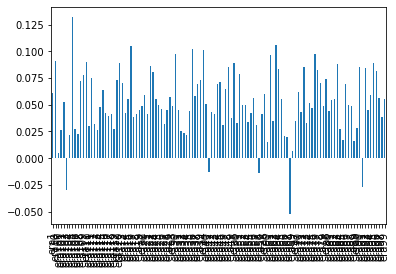

autocorrelation
0.06438256069515247
mean correlation
0.05138651185906224
sharpe
1.748514857626629
smart sharpe
1.6333774964498025

Iteration 18:

fitting on worst eras
predicting on train


<ipython-input-24-39efca956e6c>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.06115476116888174
0.04930030689251854
0.049134561736275756
0.10173129596064096
0.08934445081189057
0.06025251042263255
0.03508570509892798
0.0742448506978432
0.02823405038036954
0.09090193413110002
0.09004690951049656
0.07276685959775724
0.07043437817863663
0.04254459175824658
0.055346198818851354
0.10494050905133462
0.03846843975850327
0.04174800124812465
0.045322202810781816
0.05953445052304338
0.041225346520951604
0.08670951535024003
0.081039135133435
0.05521163601125949
0.049681170994174885
0.045756597911798313
0.03222883981821822
0.04478554645996626
0.05768954923683239
0.09753407102045619
0.04481668463952245
0.025736745046537883
0.0239259037836097
0.021916360723126974
0.044280758628009724
0.1021325804692025
0.05809983059377535
0.06938264235202504
0.07290306971673347
0.05067381419979453
-0.013065524021685645
0.04333020607762306
0.0412099816461278
0.06929995975463263
0.07121353359597488
0.0307089551367908
0.0643942076461833
0.08533328033108224
0.037936940079

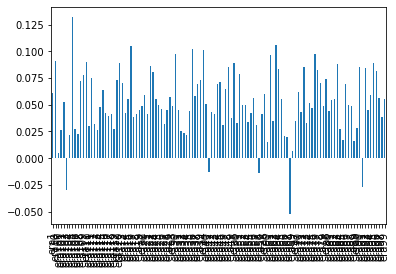

autocorrelation
0.06438256069515247
mean correlation
0.05138651185906224
sharpe
1.748514857626629
smart sharpe
1.6333774964498025

Iteration 19:

fitting on worst eras
predicting on train


<ipython-input-24-39efca956e6c>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.06115476116888174
0.04930030689251854
0.049134561736275756
0.10173129596064096
0.08934445081189057
0.06025251042263255
0.03508570509892798
0.0742448506978432
0.02823405038036954
0.09090193413110002
0.09004690951049656
0.07276685959775724
0.07043437817863663
0.04254459175824658
0.055346198818851354
0.10494050905133462
0.03846843975850327
0.04174800124812465
0.045322202810781816
0.05953445052304338
0.041225346520951604
0.08670951535024003
0.081039135133435
0.05521163601125949
0.049681170994174885
0.045756597911798313
0.03222883981821822
0.04478554645996626
0.05768954923683239
0.09753407102045619
0.04481668463952245
0.025736745046537883
0.0239259037836097
0.021916360723126974
0.044280758628009724
0.1021325804692025
0.05809983059377535
0.06938264235202504
0.07290306971673347
0.05067381419979453
-0.013065524021685645
0.04333020607762306
0.0412099816461278
0.06929995975463263
0.07121353359597488
0.0307089551367908
0.0643942076461833
0.08533328033108224
0.037936940079

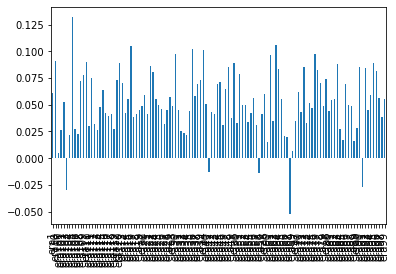

autocorrelation
0.06438256069515247
mean correlation
0.05138651185906224
sharpe
1.748514857626629
smart sharpe
1.6333774964498025

Iteration 20:

fitting on worst eras
predicting on train


<ipython-input-24-39efca956e6c>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.06115476116888174
0.04930030689251854
0.049134561736275756
0.10173129596064096
0.08934445081189057
0.06025251042263255
0.03508570509892798
0.0742448506978432
0.02823405038036954
0.09090193413110002
0.09004690951049656
0.07276685959775724
0.07043437817863663
0.04254459175824658
0.055346198818851354
0.10494050905133462
0.03846843975850327
0.04174800124812465
0.045322202810781816
0.05953445052304338
0.041225346520951604
0.08670951535024003
0.081039135133435
0.05521163601125949
0.049681170994174885
0.045756597911798313
0.03222883981821822
0.04478554645996626
0.05768954923683239
0.09753407102045619
0.04481668463952245
0.025736745046537883
0.0239259037836097
0.021916360723126974
0.044280758628009724
0.1021325804692025
0.05809983059377535
0.06938264235202504
0.07290306971673347
0.05067381419979453
-0.013065524021685645
0.04333020607762306
0.0412099816461278
0.06929995975463263
0.07121353359597488
0.0307089551367908
0.0643942076461833
0.08533328033108224
0.037936940079

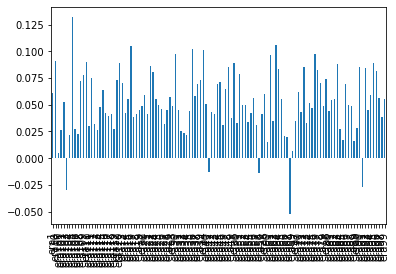

autocorrelation
0.06438256069515247
mean correlation
0.05138651185906224
sharpe
1.748514857626629
smart sharpe
1.6333774964498025

Iteration 21:

fitting on worst eras
predicting on train


<ipython-input-24-39efca956e6c>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.06115476116888174
0.04930030689251854
0.049134561736275756
0.10173129596064096
0.08934445081189057
0.06025251042263255
0.03508570509892798
0.0742448506978432
0.02823405038036954
0.09090193413110002
0.09004690951049656
0.07276685959775724
0.07043437817863663
0.04254459175824658
0.055346198818851354
0.10494050905133462
0.03846843975850327
0.04174800124812465
0.045322202810781816
0.05953445052304338
0.041225346520951604
0.08670951535024003
0.081039135133435
0.05521163601125949
0.049681170994174885
0.045756597911798313
0.03222883981821822
0.04478554645996626
0.05768954923683239
0.09753407102045619
0.04481668463952245
0.025736745046537883
0.0239259037836097
0.021916360723126974
0.044280758628009724
0.1021325804692025
0.05809983059377535
0.06938264235202504
0.07290306971673347
0.05067381419979453
-0.013065524021685645
0.04333020607762306
0.0412099816461278
0.06929995975463263
0.07121353359597488
0.0307089551367908
0.0643942076461833
0.08533328033108224
0.037936940079

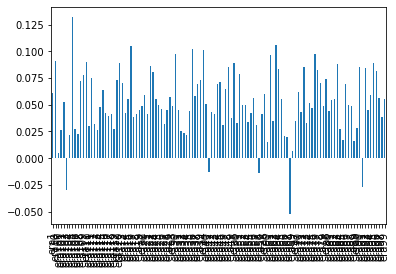

autocorrelation
0.06438256069515247
mean correlation
0.05138651185906224
sharpe
1.748514857626629
smart sharpe
1.6333774964498025

Iteration 22:

fitting on worst eras
predicting on train


<ipython-input-24-39efca956e6c>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.06115476116888174
0.04930030689251854
0.049134561736275756
0.10173129596064096
0.08934445081189057
0.06025251042263255
0.03508570509892798
0.0742448506978432
0.02823405038036954
0.09090193413110002
0.09004690951049656
0.07276685959775724
0.07043437817863663
0.04254459175824658
0.055346198818851354
0.10494050905133462
0.03846843975850327
0.04174800124812465
0.045322202810781816
0.05953445052304338
0.041225346520951604
0.08670951535024003
0.081039135133435
0.05521163601125949
0.049681170994174885
0.045756597911798313
0.03222883981821822
0.04478554645996626
0.05768954923683239
0.09753407102045619
0.04481668463952245
0.025736745046537883
0.0239259037836097
0.021916360723126974
0.044280758628009724
0.1021325804692025
0.05809983059377535
0.06938264235202504
0.07290306971673347
0.05067381419979453
-0.013065524021685645
0.04333020607762306
0.0412099816461278
0.06929995975463263
0.07121353359597488
0.0307089551367908
0.0643942076461833
0.08533328033108224
0.037936940079

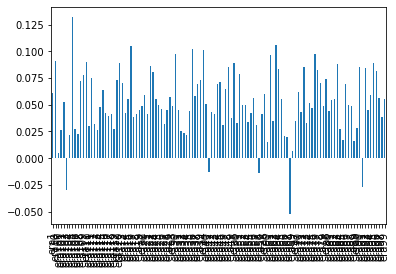

autocorrelation
0.06438256069515247
mean correlation
0.05138651185906224
sharpe
1.748514857626629
smart sharpe
1.6333774964498025

Iteration 23:

fitting on worst eras
predicting on train


<ipython-input-24-39efca956e6c>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.06115476116888174
0.04930030689251854
0.049134561736275756
0.10173129596064096
0.08934445081189057
0.06025251042263255
0.03508570509892798
0.0742448506978432
0.02823405038036954
0.09090193413110002
0.09004690951049656
0.07276685959775724
0.07043437817863663
0.04254459175824658
0.055346198818851354
0.10494050905133462
0.03846843975850327
0.04174800124812465
0.045322202810781816
0.05953445052304338
0.041225346520951604
0.08670951535024003
0.081039135133435
0.05521163601125949
0.049681170994174885
0.045756597911798313
0.03222883981821822
0.04478554645996626
0.05768954923683239
0.09753407102045619
0.04481668463952245
0.025736745046537883
0.0239259037836097
0.021916360723126974
0.044280758628009724
0.1021325804692025
0.05809983059377535
0.06938264235202504
0.07290306971673347
0.05067381419979453
-0.013065524021685645
0.04333020607762306
0.0412099816461278
0.06929995975463263
0.07121353359597488
0.0307089551367908
0.0643942076461833
0.08533328033108224
0.037936940079

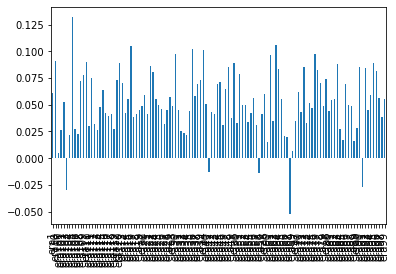

autocorrelation
0.06438256069515247
mean correlation
0.05138651185906224
sharpe
1.748514857626629
smart sharpe
1.6333774964498025

Iteration 24:

fitting on worst eras
predicting on train


<ipython-input-24-39efca956e6c>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.06115476116888174
0.04930030689251854
0.049134561736275756
0.10173129596064096
0.08934445081189057
0.06025251042263255
0.03508570509892798
0.0742448506978432
0.02823405038036954
0.09090193413110002
0.09004690951049656
0.07276685959775724
0.07043437817863663
0.04254459175824658
0.055346198818851354
0.10494050905133462
0.03846843975850327
0.04174800124812465
0.045322202810781816
0.05953445052304338
0.041225346520951604
0.08670951535024003
0.081039135133435
0.05521163601125949
0.049681170994174885
0.045756597911798313
0.03222883981821822
0.04478554645996626
0.05768954923683239
0.09753407102045619
0.04481668463952245
0.025736745046537883
0.0239259037836097
0.021916360723126974
0.044280758628009724
0.1021325804692025
0.05809983059377535
0.06938264235202504
0.07290306971673347
0.05067381419979453
-0.013065524021685645
0.04333020607762306
0.0412099816461278
0.06929995975463263
0.07121353359597488
0.0307089551367908
0.0643942076461833
0.08533328033108224
0.037936940079

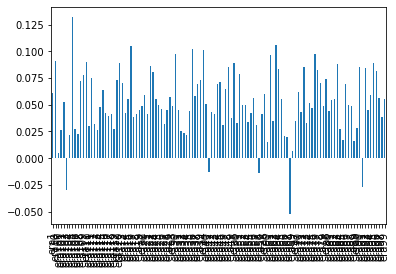

autocorrelation
0.06438256069515247
mean correlation
0.05138651185906224
sharpe
1.748514857626629
smart sharpe
1.6333774964498025

Iteration 25:

fitting on worst eras
predicting on train


<ipython-input-24-39efca956e6c>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.06325842392819536
0.04993383229604793
0.051033780168125834
0.10062905129304603
0.08651414341448267
0.0613069707638082
0.034574234312966245
0.07330618396473652
0.03064218132072445
0.08836805855611483
0.08772647952836818
0.0700582259233036
0.06800054226327835
0.042471086708121705
0.05560101414043116
0.10352165730312834
0.03965962111043293
0.04369159507532514
0.046154380092423654
0.05843365162146217
0.04368066334069408
0.08747933973793952
0.07974336167757673
0.05525974403642532
0.04809038862330466
0.04763046113318796
0.033142617994080616
0.04591607647407326
0.055225449837074975
0.09611327471840081
0.04442340274606233
0.02762877449870087
0.023117667357311994
0.023003191549619655
0.04335145474492574
0.10310448691735859
0.05833211072949896
0.06949615700101473
0.07273736868232311
0.052078372288323904
-0.011467004951425835
0.04463942630892745
0.04221122150983447
0.06760982751551954
0.07185790851104548
0.031563352678252735
0.06359204139023945
0.08474457703225272
0.03813

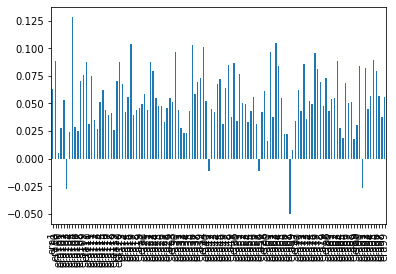

autocorrelation
0.06837889430039383
mean correlation
0.05154509397345433
sharpe
1.810165977683858
smart sharpe
1.684251882952388

Iteration 26:

fitting on worst eras
predicting on train


<ipython-input-24-39efca956e6c>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.06325842392819536
0.04993383229604793
0.051033780168125834
0.10062905129304603
0.08651414341448267
0.0613069707638082
0.034574234312966245
0.07330618396473652
0.03064218132072445
0.08836805855611483
0.08772647952836818
0.0700582259233036
0.06800054226327835
0.042471086708121705
0.05560101414043116
0.10352165730312834
0.03965962111043293
0.04369159507532514
0.046154380092423654
0.05843365162146217
0.04368066334069408
0.08747933973793952
0.07974336167757673
0.05525974403642532
0.04809038862330466
0.04763046113318796
0.033142617994080616
0.04591607647407326
0.055225449837074975
0.09611327471840081
0.04442340274606233
0.02762877449870087
0.023117667357311994
0.023003191549619655
0.04335145474492574
0.10310448691735859
0.05833211072949896
0.06949615700101473
0.07273736868232311
0.052078372288323904
-0.011467004951425835
0.04463942630892745
0.04221122150983447
0.06760982751551954
0.07185790851104548
0.031563352678252735
0.06359204139023945
0.08474457703225272
0.03813

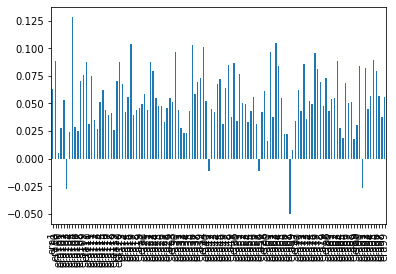

autocorrelation
0.06837889430039383
mean correlation
0.05154509397345433
sharpe
1.810165977683858
smart sharpe
1.684251882952388

Iteration 27:

fitting on worst eras
predicting on train


<ipython-input-24-39efca956e6c>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.06325842392819536
0.04993383229604793
0.051033780168125834
0.10062905129304603
0.08651414341448267
0.0613069707638082
0.034574234312966245
0.07330618396473652
0.03064218132072445
0.08836805855611483
0.08772647952836818
0.0700582259233036
0.06800054226327835
0.042471086708121705
0.05560101414043116
0.10352165730312834
0.03965962111043293
0.04369159507532514
0.046154380092423654
0.05843365162146217
0.04368066334069408
0.08747933973793952
0.07974336167757673
0.05525974403642532
0.04809038862330466
0.04763046113318796
0.033142617994080616
0.04591607647407326
0.055225449837074975
0.09611327471840081
0.04442340274606233
0.02762877449870087
0.023117667357311994
0.023003191549619655
0.04335145474492574
0.10310448691735859
0.05833211072949896
0.06949615700101473
0.07273736868232311
0.052078372288323904
-0.011467004951425835
0.04463942630892745
0.04221122150983447
0.06760982751551954
0.07185790851104548
0.031563352678252735
0.06359204139023945
0.08474457703225272
0.03813

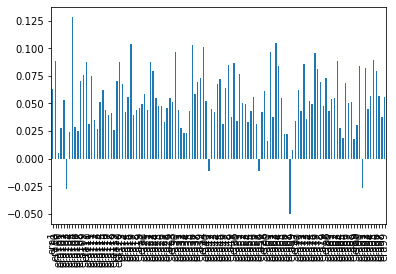

autocorrelation
0.06837889430039383
mean correlation
0.05154509397345433
sharpe
1.810165977683858
smart sharpe
1.684251882952388

Iteration 28:

fitting on worst eras
predicting on train


<ipython-input-24-39efca956e6c>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.06325842392819536
0.04993383229604793
0.051033780168125834
0.10062905129304603
0.08651414341448267
0.0613069707638082
0.034574234312966245
0.07330618396473652
0.03064218132072445
0.08836805855611483
0.08772647952836818
0.0700582259233036
0.06800054226327835
0.042471086708121705
0.05560101414043116
0.10352165730312834
0.03965962111043293
0.04369159507532514
0.046154380092423654
0.05843365162146217
0.04368066334069408
0.08747933973793952
0.07974336167757673
0.05525974403642532
0.04809038862330466
0.04763046113318796
0.033142617994080616
0.04591607647407326
0.055225449837074975
0.09611327471840081
0.04442340274606233
0.02762877449870087
0.023117667357311994
0.023003191549619655
0.04335145474492574
0.10310448691735859
0.05833211072949896
0.06949615700101473
0.07273736868232311
0.052078372288323904
-0.011467004951425835
0.04463942630892745
0.04221122150983447
0.06760982751551954
0.07185790851104548
0.031563352678252735
0.06359204139023945
0.08474457703225272
0.03813

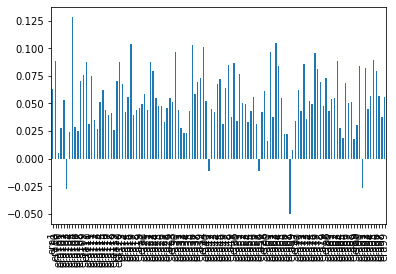

autocorrelation
0.06837889430039383
mean correlation
0.05154509397345433
sharpe
1.810165977683858
smart sharpe
1.684251882952388

Iteration 29:

fitting on worst eras
predicting on train


<ipython-input-24-39efca956e6c>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.06325842392819536
0.04993383229604793
0.051033780168125834
0.10062905129304603
0.08651414341448267
0.0613069707638082
0.034574234312966245
0.07330618396473652
0.03064218132072445
0.08836805855611483
0.08772647952836818
0.0700582259233036
0.06800054226327835
0.042471086708121705
0.05560101414043116
0.10352165730312834
0.03965962111043293
0.04369159507532514
0.046154380092423654
0.05843365162146217
0.04368066334069408
0.08747933973793952
0.07974336167757673
0.05525974403642532
0.04809038862330466
0.04763046113318796
0.033142617994080616
0.04591607647407326
0.055225449837074975
0.09611327471840081
0.04442340274606233
0.02762877449870087
0.023117667357311994
0.023003191549619655
0.04335145474492574
0.10310448691735859
0.05833211072949896
0.06949615700101473
0.07273736868232311
0.052078372288323904
-0.011467004951425835
0.04463942630892745
0.04221122150983447
0.06760982751551954
0.07185790851104548
0.031563352678252735
0.06359204139023945
0.08474457703225272
0.03813

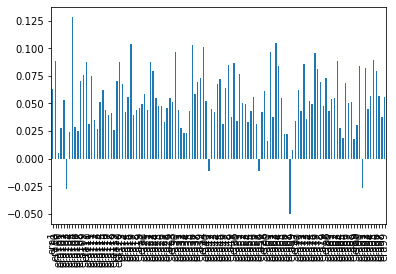

autocorrelation
0.06837889430039383
mean correlation
0.05154509397345433
sharpe
1.810165977683858
smart sharpe
1.684251882952388

Iteration 30:

fitting on worst eras
predicting on train


<ipython-input-24-39efca956e6c>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.06325842392819536
0.04993383229604793
0.051033780168125834
0.10062905129304603
0.08651414341448267
0.0613069707638082
0.034574234312966245
0.07330618396473652
0.03064218132072445
0.08836805855611483
0.08772647952836818
0.0700582259233036
0.06800054226327835
0.042471086708121705
0.05560101414043116
0.10352165730312834
0.03965962111043293
0.04369159507532514
0.046154380092423654
0.05843365162146217
0.04368066334069408
0.08747933973793952
0.07974336167757673
0.05525974403642532
0.04809038862330466
0.04763046113318796
0.033142617994080616
0.04591607647407326
0.055225449837074975
0.09611327471840081
0.04442340274606233
0.02762877449870087
0.023117667357311994
0.023003191549619655
0.04335145474492574
0.10310448691735859
0.05833211072949896
0.06949615700101473
0.07273736868232311
0.052078372288323904
-0.011467004951425835
0.04463942630892745
0.04221122150983447
0.06760982751551954
0.07185790851104548
0.031563352678252735
0.06359204139023945
0.08474457703225272
0.03813

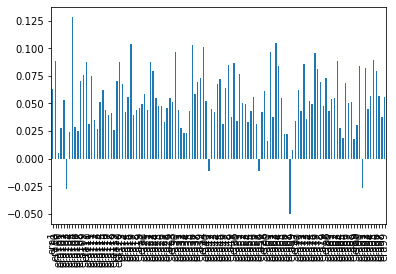

autocorrelation
0.06837889430039383
mean correlation
0.05154509397345433
sharpe
1.810165977683858
smart sharpe
1.684251882952388

Iteration 31:

fitting on worst eras
predicting on train


<ipython-input-24-39efca956e6c>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.06325842392819536
0.04993383229604793
0.051033780168125834
0.10062905129304603
0.08651414341448267
0.0613069707638082
0.034574234312966245
0.07330618396473652
0.03064218132072445
0.08836805855611483
0.08772647952836818
0.0700582259233036
0.06800054226327835
0.042471086708121705
0.05560101414043116
0.10352165730312834
0.03965962111043293
0.04369159507532514
0.046154380092423654
0.05843365162146217
0.04368066334069408
0.08747933973793952
0.07974336167757673
0.05525974403642532
0.04809038862330466
0.04763046113318796
0.033142617994080616
0.04591607647407326
0.055225449837074975
0.09611327471840081
0.04442340274606233
0.02762877449870087
0.023117667357311994
0.023003191549619655
0.04335145474492574
0.10310448691735859
0.05833211072949896
0.06949615700101473
0.07273736868232311
0.052078372288323904
-0.011467004951425835
0.04463942630892745
0.04221122150983447
0.06760982751551954
0.07185790851104548
0.031563352678252735
0.06359204139023945
0.08474457703225272
0.03813

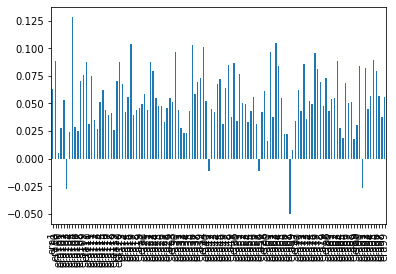

autocorrelation
0.06837889430039383
mean correlation
0.05154509397345433
sharpe
1.810165977683858
smart sharpe
1.684251882952388

Iteration 32:

fitting on worst eras
predicting on train


<ipython-input-24-39efca956e6c>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.06325842392819536
0.04993383229604793
0.051033780168125834
0.10062905129304603
0.08651414341448267
0.0613069707638082
0.034574234312966245
0.07330618396473652
0.03064218132072445
0.08836805855611483
0.08772647952836818
0.0700582259233036
0.06800054226327835
0.042471086708121705
0.05560101414043116
0.10352165730312834
0.03965962111043293
0.04369159507532514
0.046154380092423654
0.05843365162146217
0.04368066334069408
0.08747933973793952
0.07974336167757673
0.05525974403642532
0.04809038862330466
0.04763046113318796
0.033142617994080616
0.04591607647407326
0.055225449837074975
0.09611327471840081
0.04442340274606233
0.02762877449870087
0.023117667357311994
0.023003191549619655
0.04335145474492574
0.10310448691735859
0.05833211072949896
0.06949615700101473
0.07273736868232311
0.052078372288323904
-0.011467004951425835
0.04463942630892745
0.04221122150983447
0.06760982751551954
0.07185790851104548
0.031563352678252735
0.06359204139023945
0.08474457703225272
0.03813

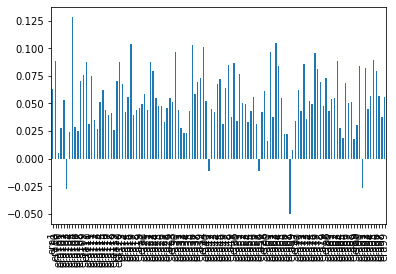

autocorrelation
0.06837889430039383
mean correlation
0.05154509397345433
sharpe
1.810165977683858
smart sharpe
1.684251882952388

Iteration 33:

fitting on worst eras
predicting on train


<ipython-input-24-39efca956e6c>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.06325842392819536
0.04993383229604793
0.051033780168125834
0.10062905129304603
0.08651414341448267
0.0613069707638082
0.034574234312966245
0.07330618396473652
0.03064218132072445
0.08836805855611483
0.08772647952836818
0.0700582259233036
0.06800054226327835
0.042471086708121705
0.05560101414043116
0.10352165730312834
0.03965962111043293
0.04369159507532514
0.046154380092423654
0.05843365162146217
0.04368066334069408
0.08747933973793952
0.07974336167757673
0.05525974403642532
0.04809038862330466
0.04763046113318796
0.033142617994080616
0.04591607647407326
0.055225449837074975
0.09611327471840081
0.04442340274606233
0.02762877449870087
0.023117667357311994
0.023003191549619655
0.04335145474492574
0.10310448691735859
0.05833211072949896
0.06949615700101473
0.07273736868232311
0.052078372288323904
-0.011467004951425835
0.04463942630892745
0.04221122150983447
0.06760982751551954
0.07185790851104548
0.031563352678252735
0.06359204139023945
0.08474457703225272
0.03813

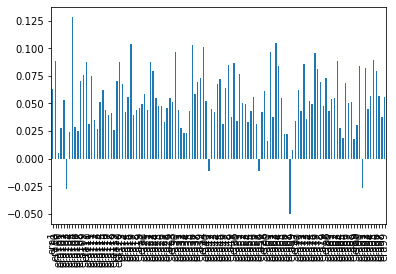

autocorrelation
0.06837889430039383
mean correlation
0.05154509397345433
sharpe
1.810165977683858
smart sharpe
1.684251882952388

Iteration 34:

fitting on worst eras
predicting on train


<ipython-input-24-39efca956e6c>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.06325842392819536
0.04993383229604793
0.051033780168125834
0.10062905129304603
0.08651414341448267
0.0613069707638082
0.034574234312966245
0.07330618396473652
0.03064218132072445
0.08836805855611483
0.08772647952836818
0.0700582259233036
0.06800054226327835
0.042471086708121705
0.05560101414043116
0.10352165730312834
0.03965962111043293
0.04369159507532514
0.046154380092423654
0.05843365162146217
0.04368066334069408
0.08747933973793952
0.07974336167757673
0.05525974403642532
0.04809038862330466
0.04763046113318796
0.033142617994080616
0.04591607647407326
0.055225449837074975
0.09611327471840081
0.04442340274606233
0.02762877449870087
0.023117667357311994
0.023003191549619655
0.04335145474492574
0.10310448691735859
0.05833211072949896
0.06949615700101473
0.07273736868232311
0.052078372288323904
-0.011467004951425835
0.04463942630892745
0.04221122150983447
0.06760982751551954
0.07185790851104548
0.031563352678252735
0.06359204139023945
0.08474457703225272
0.03813

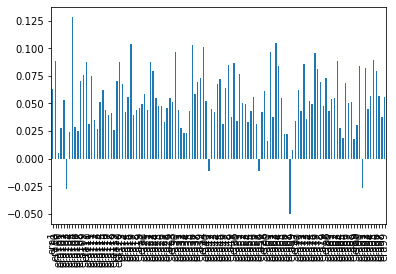

autocorrelation
0.06837889430039383
mean correlation
0.05154509397345433
sharpe
1.810165977683858
smart sharpe
1.684251882952388

Iteration 35:

fitting on worst eras
predicting on train


<ipython-input-24-39efca956e6c>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.06325842392819536
0.04993383229604793
0.051033780168125834
0.10062905129304603
0.08651414341448267
0.0613069707638082
0.034574234312966245
0.07330618396473652
0.03064218132072445
0.08836805855611483
0.08772647952836818
0.0700582259233036
0.06800054226327835
0.042471086708121705
0.05560101414043116
0.10352165730312834
0.03965962111043293
0.04369159507532514
0.046154380092423654
0.05843365162146217
0.04368066334069408
0.08747933973793952
0.07974336167757673
0.05525974403642532
0.04809038862330466
0.04763046113318796
0.033142617994080616
0.04591607647407326
0.055225449837074975
0.09611327471840081
0.04442340274606233
0.02762877449870087
0.023117667357311994
0.023003191549619655
0.04335145474492574
0.10310448691735859
0.05833211072949896
0.06949615700101473
0.07273736868232311
0.052078372288323904
-0.011467004951425835
0.04463942630892745
0.04221122150983447
0.06760982751551954
0.07185790851104548
0.031563352678252735
0.06359204139023945
0.08474457703225272
0.03813

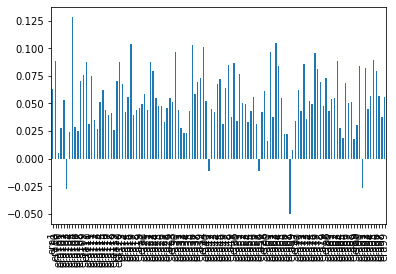

autocorrelation
0.06837889430039383
mean correlation
0.05154509397345433
sharpe
1.810165977683858
smart sharpe
1.684251882952388

Iteration 36:

fitting on worst eras
predicting on train


<ipython-input-24-39efca956e6c>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.06325842392819536
0.04993383229604793
0.051033780168125834
0.10062905129304603
0.08651414341448267
0.0613069707638082
0.034574234312966245
0.07330618396473652
0.03064218132072445
0.08836805855611483
0.08772647952836818
0.0700582259233036
0.06800054226327835
0.042471086708121705
0.05560101414043116
0.10352165730312834
0.03965962111043293
0.04369159507532514
0.046154380092423654
0.05843365162146217
0.04368066334069408
0.08747933973793952
0.07974336167757673
0.05525974403642532
0.04809038862330466
0.04763046113318796
0.033142617994080616
0.04591607647407326
0.055225449837074975
0.09611327471840081
0.04442340274606233
0.02762877449870087
0.023117667357311994
0.023003191549619655
0.04335145474492574
0.10310448691735859
0.05833211072949896
0.06949615700101473
0.07273736868232311
0.052078372288323904
-0.011467004951425835
0.04463942630892745
0.04221122150983447
0.06760982751551954
0.07185790851104548
0.031563352678252735
0.06359204139023945
0.08474457703225272
0.03813

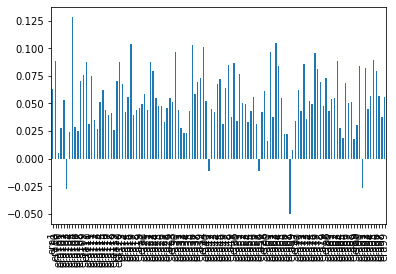

autocorrelation
0.06837889430039383
mean correlation
0.05154509397345433
sharpe
1.810165977683858
smart sharpe
1.684251882952388

Iteration 37:

fitting on worst eras
predicting on train


<ipython-input-24-39efca956e6c>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.06325842392819536
0.04993383229604793
0.051033780168125834
0.10062905129304603
0.08651414341448267
0.0613069707638082
0.034574234312966245
0.07330618396473652
0.03064218132072445
0.08836805855611483
0.08772647952836818
0.0700582259233036
0.06800054226327835
0.042471086708121705
0.05560101414043116
0.10352165730312834
0.03965962111043293
0.04369159507532514
0.046154380092423654
0.05843365162146217
0.04368066334069408
0.08747933973793952
0.07974336167757673
0.05525974403642532
0.04809038862330466
0.04763046113318796
0.033142617994080616
0.04591607647407326
0.055225449837074975
0.09611327471840081
0.04442340274606233
0.02762877449870087
0.023117667357311994
0.023003191549619655
0.04335145474492574
0.10310448691735859
0.05833211072949896
0.06949615700101473
0.07273736868232311
0.052078372288323904
-0.011467004951425835
0.04463942630892745
0.04221122150983447
0.06760982751551954
0.07185790851104548
0.031563352678252735
0.06359204139023945
0.08474457703225272
0.03813

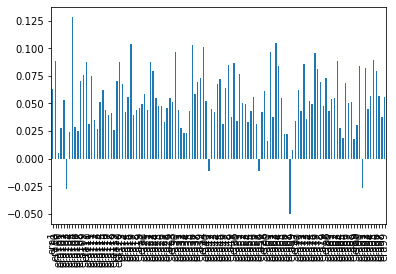

autocorrelation
0.06837889430039383
mean correlation
0.05154509397345433
sharpe
1.810165977683858
smart sharpe
1.684251882952388

Iteration 38:

fitting on worst eras
predicting on train


<ipython-input-24-39efca956e6c>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.06325842392819536
0.04993383229604793
0.051033780168125834
0.10062905129304603
0.08651414341448267
0.0613069707638082
0.034574234312966245
0.07330618396473652
0.03064218132072445
0.08836805855611483
0.08772647952836818
0.0700582259233036
0.06800054226327835
0.042471086708121705
0.05560101414043116
0.10352165730312834
0.03965962111043293
0.04369159507532514
0.046154380092423654
0.05843365162146217
0.04368066334069408
0.08747933973793952
0.07974336167757673
0.05525974403642532
0.04809038862330466
0.04763046113318796
0.033142617994080616
0.04591607647407326
0.055225449837074975
0.09611327471840081
0.04442340274606233
0.02762877449870087
0.023117667357311994
0.023003191549619655
0.04335145474492574
0.10310448691735859
0.05833211072949896
0.06949615700101473
0.07273736868232311
0.052078372288323904
-0.011467004951425835
0.04463942630892745
0.04221122150983447
0.06760982751551954
0.07185790851104548
0.031563352678252735
0.06359204139023945
0.08474457703225272
0.03813

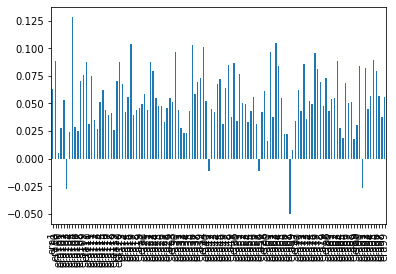

autocorrelation
0.06837889430039383
mean correlation
0.05154509397345433
sharpe
1.810165977683858
smart sharpe
1.684251882952388

Iteration 39:

fitting on worst eras
predicting on train


<ipython-input-24-39efca956e6c>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.06325842392819536
0.04993383229604793
0.051033780168125834
0.10062905129304603
0.08651414341448267
0.0613069707638082
0.034574234312966245
0.07330618396473652
0.03064218132072445
0.08836805855611483
0.08772647952836818
0.0700582259233036
0.06800054226327835
0.042471086708121705
0.05560101414043116
0.10352165730312834
0.03965962111043293
0.04369159507532514
0.046154380092423654
0.05843365162146217
0.04368066334069408
0.08747933973793952
0.07974336167757673
0.05525974403642532
0.04809038862330466
0.04763046113318796
0.033142617994080616
0.04591607647407326
0.055225449837074975
0.09611327471840081
0.04442340274606233
0.02762877449870087
0.023117667357311994
0.023003191549619655
0.04335145474492574
0.10310448691735859
0.05833211072949896
0.06949615700101473
0.07273736868232311
0.052078372288323904
-0.011467004951425835
0.04463942630892745
0.04221122150983447
0.06760982751551954
0.07185790851104548
0.031563352678252735
0.06359204139023945
0.08474457703225272
0.03813

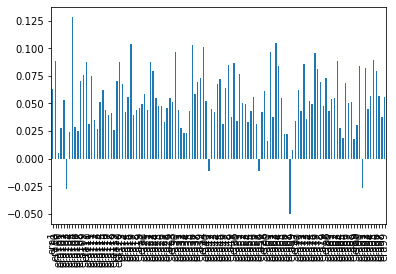

autocorrelation
0.06837889430039383
mean correlation
0.05154509397345433
sharpe
1.810165977683858
smart sharpe
1.684251882952388

Iteration 40:

fitting on worst eras
predicting on train


<ipython-input-24-39efca956e6c>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.06325842392819536
0.04993383229604793
0.051033780168125834
0.10062905129304603
0.08651414341448267
0.0613069707638082
0.034574234312966245
0.07330618396473652
0.03064218132072445
0.08836805855611483
0.08772647952836818
0.0700582259233036
0.06800054226327835
0.042471086708121705
0.05560101414043116
0.10352165730312834
0.03965962111043293
0.04369159507532514
0.046154380092423654
0.05843365162146217
0.04368066334069408
0.08747933973793952
0.07974336167757673
0.05525974403642532
0.04809038862330466
0.04763046113318796
0.033142617994080616
0.04591607647407326
0.055225449837074975
0.09611327471840081
0.04442340274606233
0.02762877449870087
0.023117667357311994
0.023003191549619655
0.04335145474492574
0.10310448691735859
0.05833211072949896
0.06949615700101473
0.07273736868232311
0.052078372288323904
-0.011467004951425835
0.04463942630892745
0.04221122150983447
0.06760982751551954
0.07185790851104548
0.031563352678252735
0.06359204139023945
0.08474457703225272
0.03813

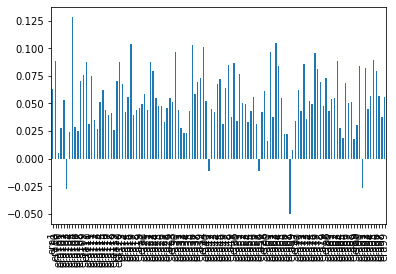

autocorrelation
0.06837889430039383
mean correlation
0.05154509397345433
sharpe
1.810165977683858
smart sharpe
1.684251882952388


In [27]:
boost_model = era_boost_train(X_train, y_train,
                              era_col=train["era"], proportion=0.5,
                              trees_per_step=10, num_iters=40, test_model=boost_model)

In [ ]:
tournament_calc = tournament.copy()
X_tournament, y_tournament = clean_for_xgboost(tournament_calc)
tournament_calc.loc[:,"prediction"] = model.predict(X_tournament)
tournament_calc.set_index('id', inplace=True)
tournament_calc['prediction'].to_csv(f"era_boost_submission.csv", header=True)

In [28]:
save_model(boost_model, 'era_boosted_qurty.pkl')